<a href="https://colab.research.google.com/github/dina-masry/Maternal-Mortality-Prediction-CTG-Analysis/blob/main/Maternal-Mortality-Prediction-CTG-Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import required packages

In [ ]:
!pip install keras_tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
seed =42
random.seed(seed)
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dropout
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
# ignore warnings
import warnings
warnings.filterwarnings('ignore')


##Custom functions

In [ ]:
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

##Load the data

In [ ]:
path= '/content/drive/MyDrive/AXSOSACADEMY/05-IntermediateML/Week19/Data/mortality_fetal_prediction.xlsx - data.csv'
df = pd.read_csv(path)
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,68,198,6,1,141,136,140,12,0,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,68,198,5,1,141,135,138,13,0,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,53,170,11,0,137,134,137,13,1,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,53,170,9,0,137,136,138,11,1,1


##Inspect the data

In [ ]:
df.isna().sum()

,0
baseline value,0
accelerations,0
fetal_movement,0
uterine_contractions,0
light_decelerations,0
severe_decelerations,0
prolongued_decelerations,0
abnormal_short_term_variability,0
mean_value_of_short_term_variability,0
percentage_of_time_with_abnormal_long_term_variability,0


In [ ]:
df.duplicated().sum()

np.int64(13)

##Split the data

In [ ]:
y= df['fetal_health']
X = df.drop(columns='fetal_health')
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .25, random_state=42)

# One-hot encode the target variable
y_train_encoded = tf.keras.utils.to_categorical(y_train - 1, num_classes=3)
y_test_encoded = tf.keras.utils.to_categorical(y_test - 1, num_classes=3)

##Preprocessing

In [ ]:
# preprocessing
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

##Neural network

In [ ]:
input_shape = X_train_scaled.shape[1]
input_shape

21

In [ ]:
model = Sequential()
model.add(Dense(21, activation='relu', input_shape=(input_shape,)))
model.add(Dense(15, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.metrics.Precision(name= 'precision'), tf.metrics.Recall(name = 'recall')])

In [ ]:
history = model.fit(X_train_scaled, y_train_encoded, epochs=35, batch_size=32, validation_split=0.2)

Epoch 1/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5967 - loss: 1.1592 - precision: 0.5115 - recall: 0.1898 - val_accuracy: 0.7806 - val_loss: 0.9258 - val_precision: 0.7857 - val_recall: 0.4483
Epoch 2/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7533 - loss: 0.8432 - precision: 0.8105 - recall: 0.4982 - val_accuracy: 0.8088 - val_loss: 0.6717 - val_precision: 0.8879 - val_recall: 0.6458
Epoch 3/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8018 - loss: 0.6532 - precision: 0.8875 - recall: 0.6362 - val_accuracy: 0.8652 - val_loss: 0.4694 - val_precision: 0.9416 - val_recall: 0.7586
Epoch 4/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8394 - loss: 0.4871 - precision: 0.8937 - recall: 0.7467 - val_accuracy: 0.8809 - val_loss: 0.3521 - val_precision: 0.9170 - val_recall: 0.8307
Epoch 5/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8668 - loss: 0.3862 - precision: 0.8998 - recall: 0.8204 - val_accuracy: 0.8966 - val_loss: 0.3002 - va

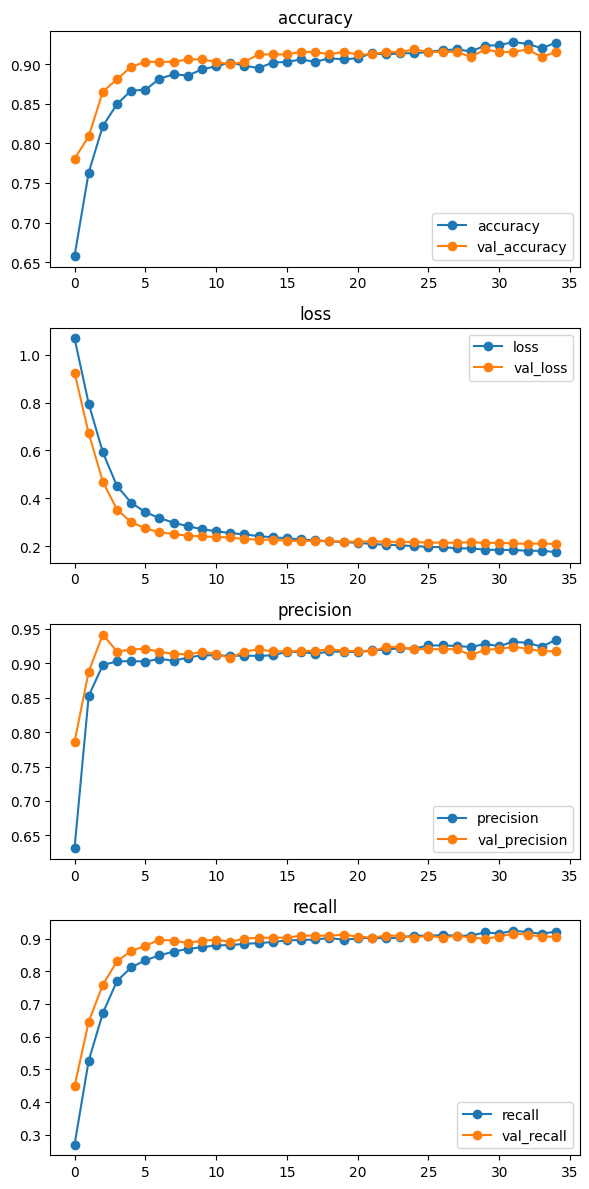

In [ ]:
plot_history(history);

In [ ]:
model.evaluate(X_test_scaled, y_test_encoded,return_dict=True)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8690 - loss: 0.2893 - precision: 0.8758 - recall: 0.8585


{'accuracy': 0.88345867395401,
 'loss': 0.26713210344314575,
 'precision': 0.8910133838653564,
 'recall': 0.8759398460388184}

Training set
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1242
           1       0.77      0.69      0.73       213
           2       0.90      0.83      0.86       139

   micro avg       0.93      0.92      0.92      1594
   macro avg       0.87      0.83      0.85      1594
weighted avg       0.93      0.92      0.92      1594
 samples avg       0.92      0.92      0.92      1594



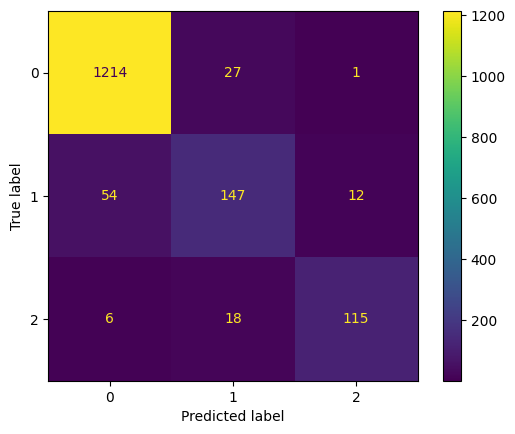

In [ ]:
# evaluate the model with sklearn metrics
# evaluate on training set
print('Training set')
train_preds = model.predict(X_train_scaled).round()
print(classification_report(y_train_encoded, train_preds))
# Convert one-hot encoded predictions to single labels for confusion matrix
train_preds_single_label = np.argmax(train_preds, axis=1)
y_train_single_label = np.argmax(y_train_encoded, axis=1)

ConfusionMatrixDisplay.from_predictions(y_train_single_label, train_preds_single_label);

Testing set
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       413
           1       0.65      0.67      0.66        82
           2       0.76      0.76      0.76        37

   micro avg       0.89      0.88      0.88       532
   macro avg       0.79      0.78      0.79       532
weighted avg       0.89      0.88      0.88       532
 samples avg       0.88      0.88      0.88       532



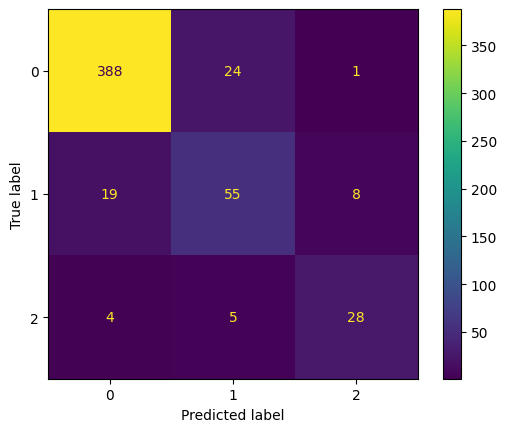

In [ ]:
print('Testing set')
test_preds = model.predict(X_test_scaled).round()
print(classification_report(y_test_encoded, test_preds))

test_preds_single_label = np.argmax(test_preds, axis=1)
y_test_single_label = np.argmax(y_test_encoded, axis=1)
ConfusionMatrixDisplay.from_predictions(y_test_single_label, test_preds_single_label);

##Second Neural Network

- Tune hyperparameters: number of units , dropout rates , learning rates , optimizer type.

In [ ]:
def build_model(hp):
    # Instantiate Model
    model = Sequential()
    # hidden layers
    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=11, max_value=21, step=5),input_dim = input_shape, activation='relu'))
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.2, step=0.01)))
    model.add(Dense(units=hp.Int('units', min_value=5, max_value=15, step=5), activation='relu'))
    model.add(Dense(3, activation = 'softmax'))

    # Try different optimizers and learning rates by passing their string names
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'nadam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[.01, .001, .0001])
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Custom metric for recall of class 2 (index 1 in one-hot encoding)
    recall_class_3 = tf.keras.metrics.Recall(class_id=2, name='recall_class_3')

    # Compile Model with the chosen optimizer and learning rate and custom metric
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',tf.metrics.Precision(name= 'precision'), tf.metrics.Recall(name = 'recall'), recall_class_3,f1_score_class_3])
    return model

In [ ]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [ ]:
# Define tuner object
tuner = kt.Hyperband(build_model, objective=kt.Objective("val_recall_class_3", direction="max"), max_epochs=100, directory=folder, overwrite = True, seed = 42 , project_name='tuning')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(X_train_scaled, y_train_encoded, epochs=30, validation_split=0.2, callbacks=[early_stopping])

Trial 254 Complete [00h 00m 27s]
val_recall_class_3: 0.7666666507720947

Best val_recall_class_3 So Far: 1.0
Total elapsed time: 00h 47m 33s


In [ ]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675 (2.64 KB)

 Trainable params: 675 (2.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'units': 16,
 'dropout_value': 0.0,
 'optimizer': 'rmsprop',
 'learning_rate': 0.0001,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [ ]:
history = best_model.fit(X_train_scaled, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.1319 - f1_score_class_3: 0.2828 - loss: 1.4552 - precision: 0.1687 - recall: 0.0863 - recall_class_3: 0.9587 - val_accuracy: 0.1599 - val_f1_score_class_3: 0.3244 - val_loss: 1.3993 - val_precision: 0.2208 - val_recall: 0.1066 - val_recall_class_3: 1.0000
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1533 - f1_score_class_3: 0.2850 - loss: 1.3918 - precision: 0.1755 - recall: 0.0803 - recall_class_3: 0.9320 - val_accuracy: 0.1975 - val_f1_score_class_3: 0.3350 - val_loss: 1.3170 - val_precision: 0.2361 - val_recall: 0.1066 - val_recall_class_3: 0.9667
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1830 - f1_score_class_3: 0.3020 - loss: 1.3305 - precision: 0.2034 - recall: 0.0890 - recall_class_3: 0.9144 - val_accuracy: 0.2382 - val_f1_score_class_3: 0.3410 - val_loss: 1.2386 - val_precision: 0.2628 - val_recall: 0.1129 - val_recall_class_3: 0.9333
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0

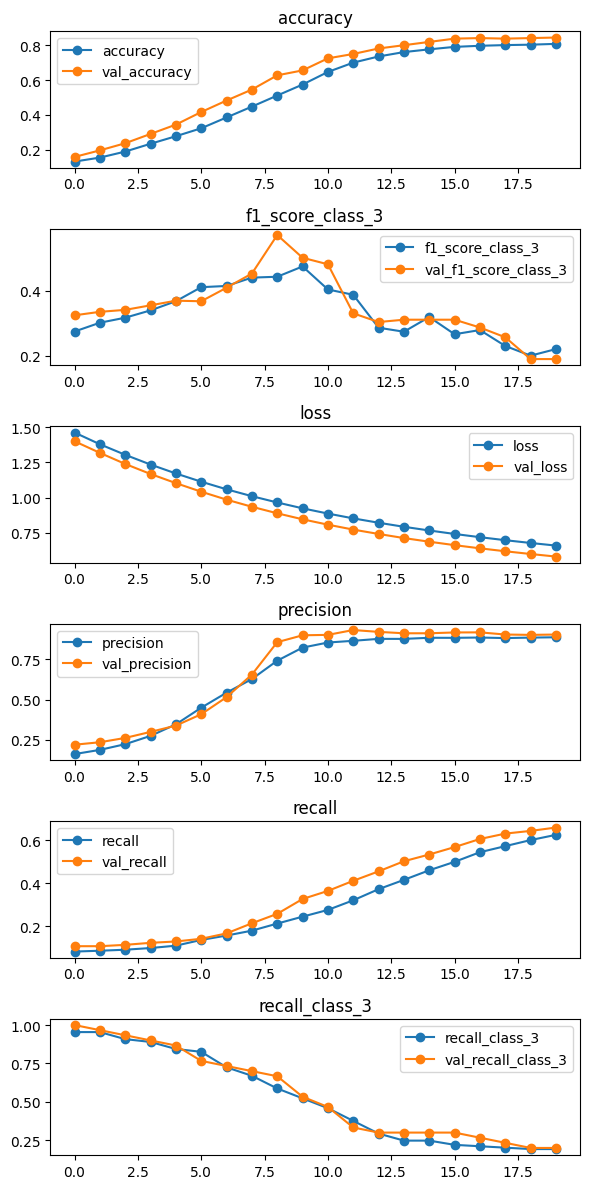

In [ ]:
plot_history(history);

In [ ]:
# evaluate on unseen data
best_model.evaluate(X_test_scaled, y_test_encoded,return_dict=True)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8301 - f1_score_class_3: 0.2474 - loss: 0.6811 - precision: 0.8842 - recall: 0.5906 - recall_class_3: 0.1870


{'accuracy': 0.8289473652839661,
 'f1_score_class_3': 0.21092434227466583,
 'loss': 0.6616699695587158,
 'precision': 0.8950276374816895,
 'recall': 0.6090225577354431,
 'recall_class_3': 0.18918919563293457}

Training set
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1242
           1       0.00      0.00      0.00       213
           2       0.78      0.21      0.33       139

   micro avg       0.89      0.64      0.75      1594
   macro avg       0.56      0.34      0.39      1594
weighted avg       0.76      0.64      0.69      1594
 samples avg       0.64      0.64      0.64      1594



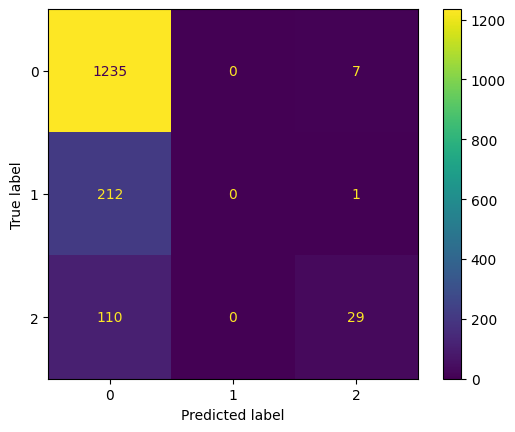

In [ ]:
#evaluate on training data using sklearn metrics
print('Training set')
train_preds = best_model.predict(X_train_scaled).round()
print(classification_report(y_train_encoded, train_preds))
# Convert one-hot encoded predictions to single labels for confusion matrix
train_preds_single_label = np.argmax(train_preds, axis=1)
y_train_single_label = np.argmax(y_train_encoded, axis=1)

ConfusionMatrixDisplay.from_predictions(y_train_single_label, train_preds_single_label);

Testing set
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       413
           1       0.00      0.00      0.00        82
           2       0.78      0.19      0.30        37

   micro avg       0.90      0.61      0.72       532
   macro avg       0.56      0.32      0.38       532
weighted avg       0.75      0.61      0.66       532
 samples avg       0.61      0.61      0.61       532



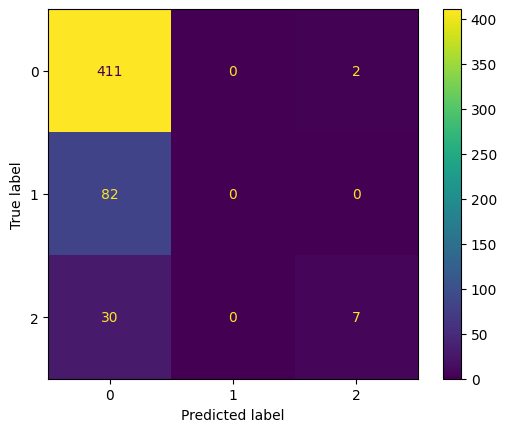

In [ ]:
# testing data
print('Testing set')
test_preds = best_model.predict(X_test_scaled).round()
print(classification_report(y_test_encoded, test_preds))

test_preds_single_label = np.argmax(test_preds, axis=1)
y_test_single_label = np.argmax(y_test_encoded, axis=1)
ConfusionMatrixDisplay.from_predictions(y_test_single_label, test_preds_single_label);

##Third model:

- try to get the best f1-score for class 3

In [ ]:
# Custom metric for f1-score of class 3 (index 2 in one-hot encoding)
# F1 = 2 * (precision * recall) / (precision + recall)
# We need to calculate precision and recall for class 3 first
def f1_score_class_3(y_true, y_pred):
        # Get the true and predicted labels for class 3
        y_true_class_3 = y_true[:, 2]
        y_pred_class_3 = y_pred[:, 2]

        # Calculate precision and recall for class 3
        true_positives = tf.reduce_sum(tf.cast(y_true_class_3 * tf.round(y_pred_class_3), tf.float32))
        possible_positives = tf.reduce_sum(tf.cast(y_true_class_3, tf.float32))
        predicted_positives = tf.reduce_sum(tf.cast(tf.round(y_pred_class_3), tf.float32))

        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

        # Calculate F1-score
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return f1

In [ ]:
tuner_2 = kt.Hyperband(build_model, objective=kt.Objective("f1_score_class_3", direction="max"), max_epochs=100, directory=folder, overwrite = True, seed = 42 , project_name='tuning_2')

In [ ]:
tuner_2.search(X_train_scaled, y_train_encoded, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 254 Complete [00h 00m 36s]
f1_score_class_3: 0.817876935005188

Best f1_score_class_3 So Far: 0.8610759973526001
Total elapsed time: 01h 13m 50s


In [ ]:
best_model_2 = tuner_2.get_best_models()[0]
best_model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675 (2.64 KB)

 Trainable params: 675 (2.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_2 = best_model_2.fit(X_train_scaled, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9278 - f1_score_class_3: 0.7428 - loss: 0.1602 - precision: 0.9302 - recall: 0.9246 - recall_class_3: 0.8307 - val_accuracy: 0.9248 - val_f1_score_class_3: 0.8817 - val_loss: 0.1857 - val_precision: 0.9277 - val_recall: 0.9248 - val_recall_class_3: 0.8667
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9338 - f1_score_class_3: 0.8438 - loss: 0.1413 - precision: 0.9409 - recall: 0.9320 - recall_class_3: 0.9127 - val_accuracy: 0.9154 - val_f1_score_class_3: 0.8144 - val_loss: 0.2406 - val_precision: 0.9151 - val_recall: 0.9122 - val_recall_class_3: 0.8333
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9374 - f1_score_class_3: 0.8573 - loss: 0.1435 - precision: 0.9431 - recall: 0.9351 - recall_class_3: 0.8589 - val_accuracy: 0.9216 - val_f1_score_class_3: 0.9166 - val_loss: 0.2312 - val_precision: 0.9214 - val_recall: 0.9185 - val_recall_class_3: 0.9000
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0

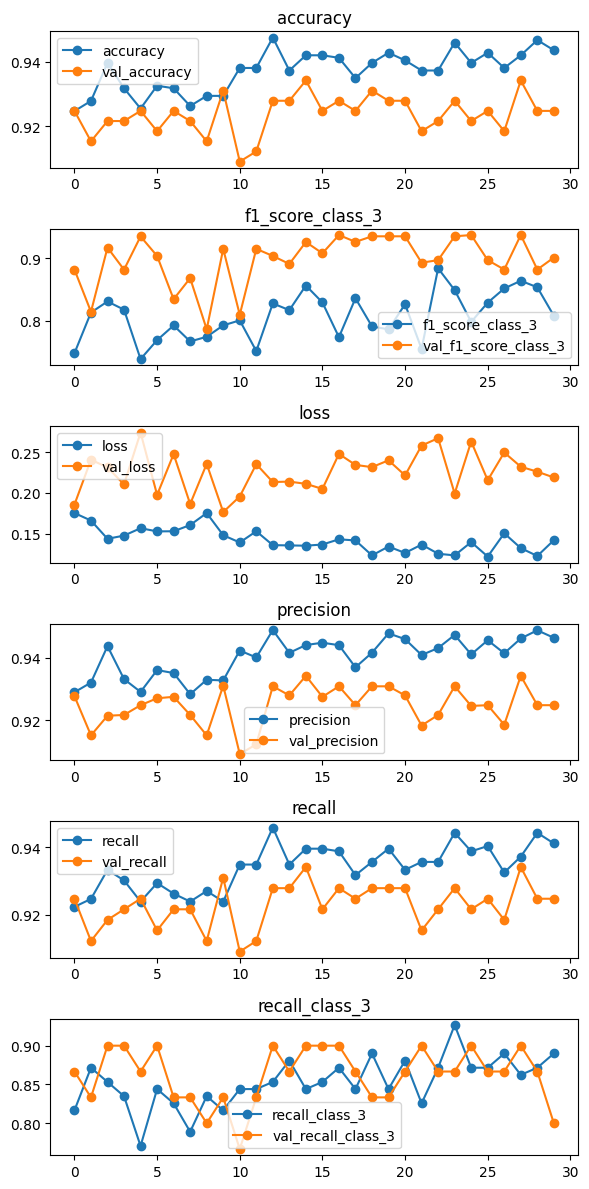

In [ ]:
plot_history(history_2);

In [ ]:
# evaluate on unseen data
best_model_2.evaluate(X_test_scaled, y_test_encoded,return_dict=True)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8833 - f1_score_class_3: 0.6579 - loss: 0.3323 - precision: 0.8852 - recall: 0.8755 - recall_class_3: 0.8876


{'accuracy': 0.8909774422645569,
 'f1_score_class_3': 0.6428140997886658,
 'loss': 0.31593695282936096,
 'precision': 0.8939393758773804,
 'recall': 0.8872180581092834,
 'recall_class_3': 0.8648648858070374}

Training set
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1242
           1       0.79      0.91      0.84       213
           2       0.96      0.92      0.94       139

   micro avg       0.95      0.95      0.95      1594
   macro avg       0.91      0.93      0.92      1594
weighted avg       0.96      0.95      0.95      1594
 samples avg       0.95      0.95      0.95      1594



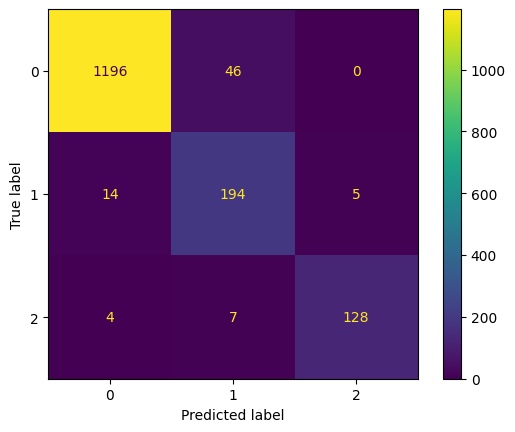

In [ ]:
#evaluate on training data using sklearn metrics
print('Training set')
train_preds = best_model_2.predict(X_train_scaled).round()
print(classification_report(y_train_encoded, train_preds))
# Convert one-hot encoded predictions to single labels for confusion matrix
train_preds_single_label = np.argmax(train_preds, axis=1)
y_train_single_label = np.argmax(y_train_encoded, axis=1)

ConfusionMatrixDisplay.from_predictions(y_train_single_label, train_preds_single_label);

Testing set
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       413
           1       0.64      0.74      0.69        82
           2       0.76      0.86      0.81        37

   micro avg       0.89      0.89      0.89       532
   macro avg       0.79      0.84      0.81       532
weighted avg       0.91      0.89      0.89       532
 samples avg       0.89      0.89      0.89       532



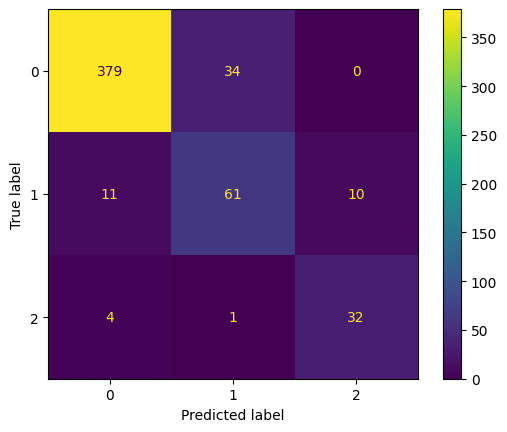

In [ ]:
# testing data
print('Testing set')
test_preds = best_model_2.predict(X_test_scaled).round()
print(classification_report(y_test_encoded, test_preds))

test_preds_single_label = np.argmax(test_preds, axis=1)
y_test_single_label = np.argmax(y_test_encoded, axis=1)
ConfusionMatrixDisplay.from_predictions(y_test_single_label, test_preds_single_label);

##Fourth neural network:

In [ ]:
# Define tuner object
tuner_3 = kt.Hyperband(build_model, objective=kt.Objective('val_loss', direction='min'), max_epochs=100, directory=folder, overwrite = True, seed = 42 , project_name='tuning_3')

In [ ]:
tuner_3.search(X_train_scaled, y_train_encoded, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 254 Complete [00h 00m 39s]
val_loss: 0.21129366755485535

Best val_loss So Far: 0.16827309131622314
Total elapsed time: 01h 38m 07s


In [ ]:
best_model_3 = tuner_3.get_best_models()[0]
best_model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675 (2.64 KB)

 Trainable params: 675 (2.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_3 = best_model_3.fit(X_train_scaled, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9136 - f1_score_class_3: 0.7964 - loss: 0.1863 - precision: 0.9227 - recall: 0.9131 - recall_class_3: 0.8061 - val_accuracy: 0.9091 - val_f1_score_class_3: 0.8119 - val_loss: 0.2024 - val_precision: 0.9111 - val_recall: 0.8997 - val_recall_class_3: 0.9000
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9121 - f1_score_class_3: 0.6886 - loss: 0.1927 - precision: 0.9167 - recall: 0.9039 - recall_class_3: 0.7817 - val_accuracy: 0.9216 - val_f1_score_class_3: 0.8031 - val_loss: 0.1848 - val_precision: 0.9270 - val_recall: 0.9154 - val_recall_class_3: 0.9000
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9361 - f1_score_class_3: 0.8442 - loss: 0.1596 - precision: 0.9376 - recall: 0.9299 - recall_class_3: 0.8724 - val_accuracy: 0.9310 - val_f1_score_class_3: 0.8413 - val_loss: 0.1815 - val_precision: 0.9306 - val_recall: 0.9248 - val_recall_class_3: 0.9000
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━

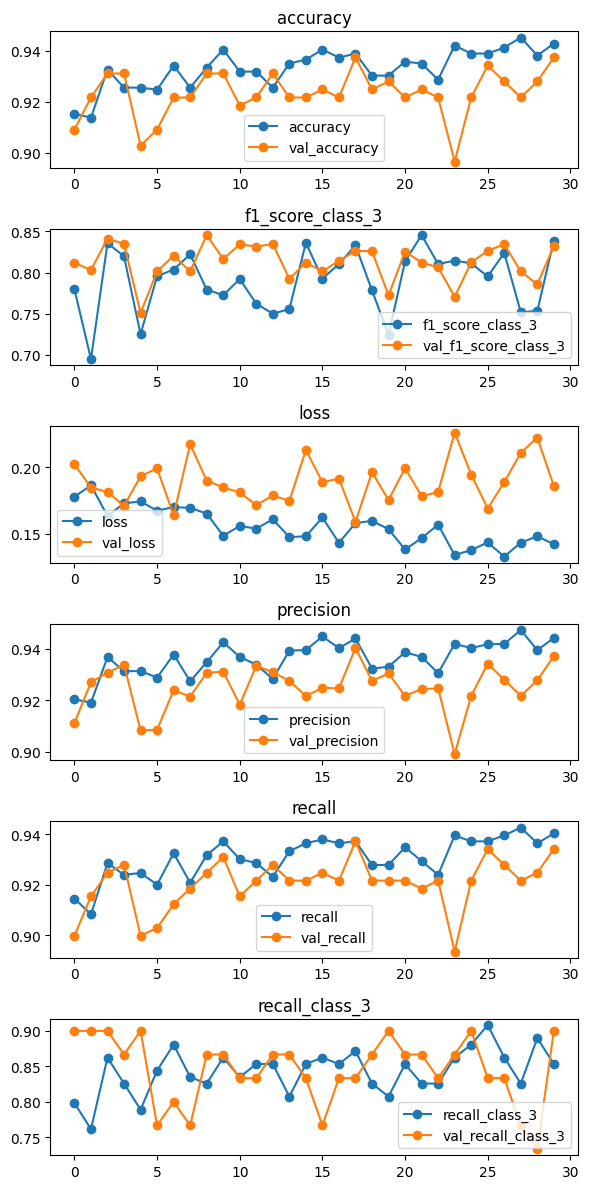

In [ ]:
plot_history(history_3);

In [ ]:
#evaluate on unseen data
best_model_3.evaluate(X_test_scaled, y_test_encoded,return_dict=True)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9218 - f1_score_class_3: 0.6680 - loss: 0.2167 - precision: 0.9242 - recall: 0.9163 - recall_class_3: 0.8520 


{'accuracy': 0.9172932505607605,
 'f1_score_class_3': 0.6260250210762024,
 'loss': 0.22159290313720703,
 'precision': 0.9222011566162109,
 'recall': 0.9135338068008423,
 'recall_class_3': 0.837837815284729}

Training set
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1242
           1       0.87      0.82      0.85       213
           2       0.98      0.87      0.92       139

   micro avg       0.96      0.95      0.96      1594
   macro avg       0.94      0.89      0.92      1594
weighted avg       0.96      0.95      0.96      1594
 samples avg       0.95      0.95      0.95      1594



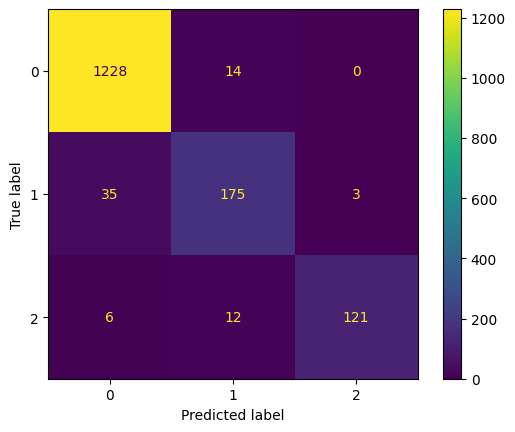

In [ ]:
# training set
print('Training set')
train_preds = best_model_3.predict(X_train_scaled).round()
print(classification_report(y_train_encoded, train_preds))
# Convert one-hot encoded predictions to single labels for confusion matrix
train_preds_single_label = np.argmax(train_preds, axis=1)
y_train_single_label = np.argmax(y_train_encoded, axis=1)

ConfusionMatrixDisplay.from_predictions(y_train_single_label, train_preds_single_label);

Testing set
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       413
           1       0.82      0.66      0.73        82
           2       0.79      0.84      0.82        37

   micro avg       0.92      0.91      0.92       532
   macro avg       0.85      0.82      0.84       532
weighted avg       0.92      0.91      0.91       532
 samples avg       0.91      0.91      0.91       532



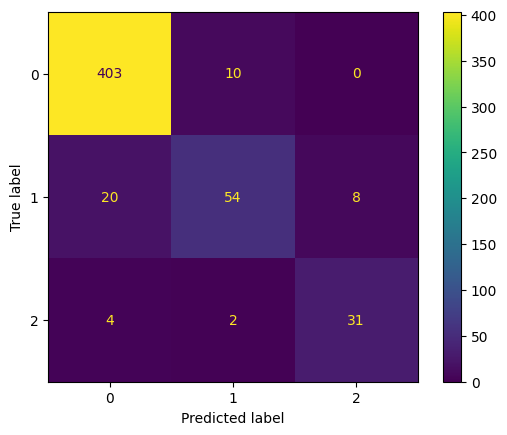

In [ ]:
# testing data
print('Testing set')
test_preds = best_model_3.predict(X_test_scaled).round()
print(classification_report(y_test_encoded, test_preds))

test_preds_single_label = np.argmax(test_preds, axis=1)
y_test_single_label = np.argmax(y_test_encoded, axis=1)
ConfusionMatrixDisplay.from_predictions(y_test_single_label, test_preds_single_label);

##Logistic regression

In [ ]:
lr= LogisticRegression()
lr.fit(X_train_scaled, y_train)

LogisticRegression()

Training set
              precision    recall  f1-score   support

           1       0.95      0.96      0.95      1242
           2       0.69      0.67      0.68       213
           3       0.85      0.79      0.82       139

    accuracy                           0.91      1594
   macro avg       0.83      0.81      0.82      1594
weighted avg       0.90      0.91      0.91      1594



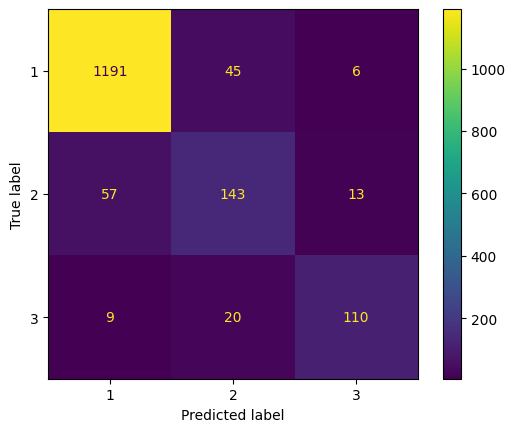

In [ ]:
# evaluate on training set
print('Training set')
train_preds = lr.predict(X_train_scaled)
print(classification_report(y_train, train_preds))
ConfusionMatrixDisplay.from_predictions(y_train, train_preds);

Testing set
              precision    recall  f1-score   support

           1       0.95      0.94      0.94       413
           2       0.66      0.66      0.66        82
           3       0.70      0.81      0.75        37

    accuracy                           0.89       532
   macro avg       0.77      0.80      0.78       532
weighted avg       0.89      0.89      0.89       532



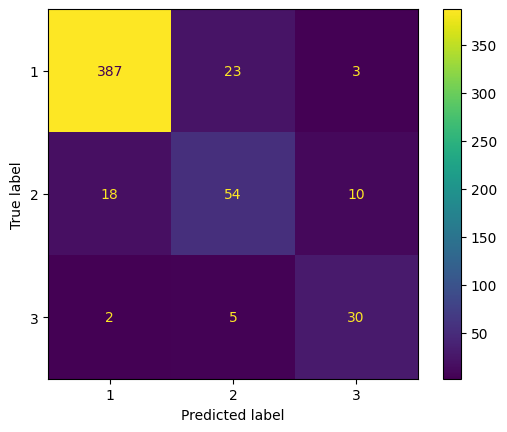

In [ ]:
# evaluate on testing set
print('Testing set')
test_preds = lr.predict(X_test_scaled)
print(classification_report(y_test, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds);